In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("Loading data... please wait.")
df = pd.read_excel('online_retail_II.xlsx')

print("Data loaded successfully!")
print("--- Column Names ---")
print(df.columns)
print("--------------------")
df.head()

Loading data... please wait.
Data loaded successfully!
--- Column Names ---
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
--------------------


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# 1. Drop rows where Customer ID is missing
df.dropna(subset=['Customer ID'], inplace=True)

# 2. Remove Cancelled orders (Invoice starts with 'C')
# We convert to string first just to be safe
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# 3. Sanity Check: Ensure Quantity is greater than 0 (removes any weird errors)
df = df[df['Quantity'] > 0]

# 4. Create 'TotalAmount' column
df['TotalAmount'] = df['Quantity'] * df['Price']

# 5. Make Customer ID look cleaner (convert float 12345.0 to integer 12345)
df['Customer ID'] = df['Customer ID'].astype(int)

print("Cleaning complete!")
print(f"Final shape: {df.shape}")
df.head()

Cleaning complete!
Final shape: (407695, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [6]:
df['InvoiceData'] = pd.to_datetime(df['InvoiceDate'])
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('MonthYear')['TotalAmount'].sum().reset_index()
monthly_sales['MonthYear'] = monthly_sales['MonthYear'].astype(str)

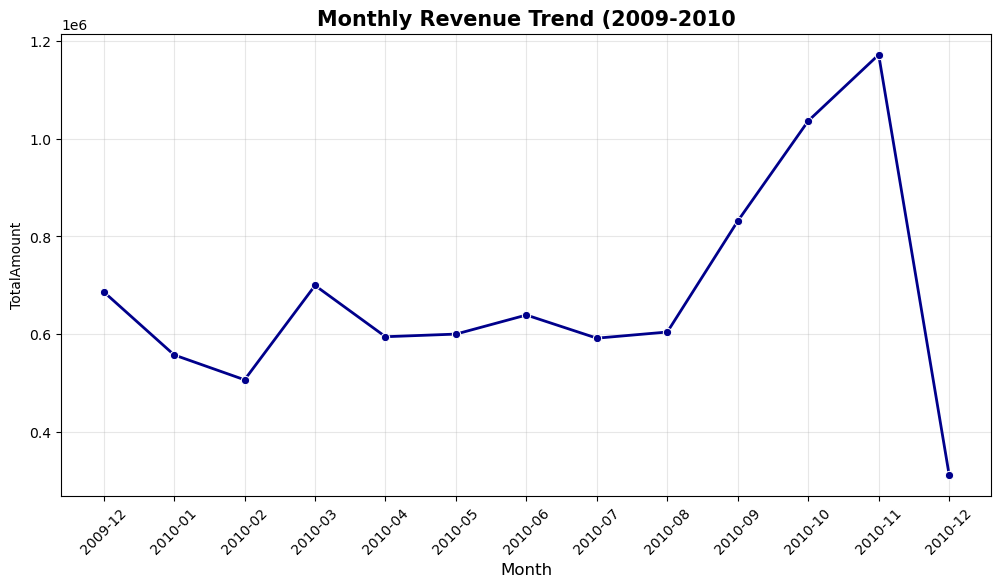

In [8]:
plt.figure(figsize = (12,6))
sns.lineplot(data = monthly_sales ,
            x = 'MonthYear', y = 'TotalAmount' , marker = 'o' , color = 'darkblue' , linewidth = 2)
plt.title('Monthly Revenue Trend (2009-2010' , fontsize = 15 , weight = 'bold')
plt.xlabel('Total Revenue ($)' , fontsize = 12)
plt.xlabel('Month' , fontsize = 12)
plt.xticks(rotation = 45)
plt.grid(True , alpha=0.3)
plt.show()

In [9]:
import datetime as dt

In [11]:
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Reference Date used for analysis : {latest_date}")

Reference Date used for analysis : 2010-12-10 20:01:00


In [12]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print("\nRFM Table Created:")
rfm.head()


RFM Table Created:


,Recency,Frequency,Monetary
Customer ID,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93


In [13]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

In [14]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=4, labels=m_labels)

rfm['RFM_Sum'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

In [15]:
def get_segment(score):
    if score >= 10:
        return 'Champions'       
    elif score >= 7:
        return 'Loyal'           
    elif score >= 5:
        return 'Potential'       
    else:
        return 'Needs Attention' 

rfm['Segment'] = rfm['RFM_Sum'].apply(get_segment)


print("Segmentation Complete!")
rfm.head()

Segmentation Complete!


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Sum,Segment
Customer ID,,,,,,,,
12346,165,11,372.86,1,4,2,7,Loyal
12347,3,2,1323.32,4,2,3,9,Loyal
12348,74,1,222.16,2,1,1,4,Needs Attention
12349,43,3,2671.14,3,3,4,10,Champions
12351,11,1,300.93,4,1,1,6,Potential


C:\Users\shashwat\AppData\Local\Temp\ipykernel_18532\687929243.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm,


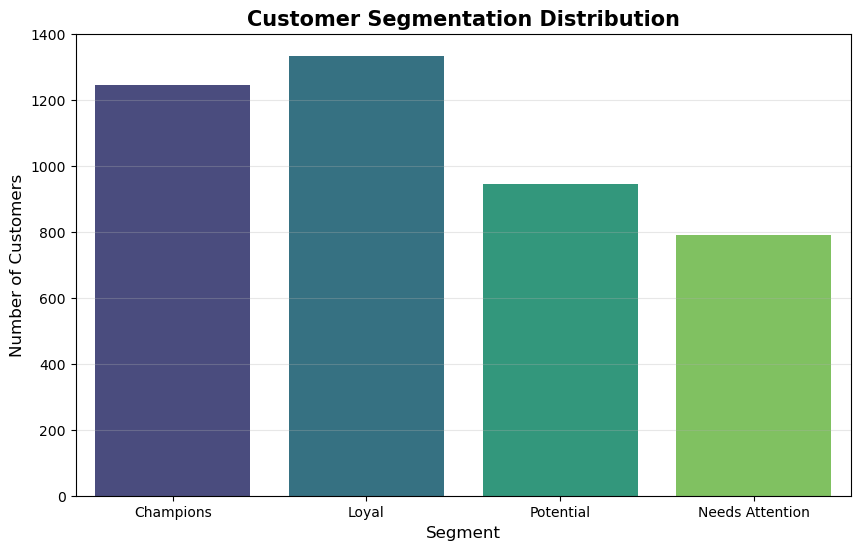

--- Average Customer Behavior by Segment ---
                 Recency  Frequency  Monetary
Segment                                      
Champions          21.98      10.37   5387.02
Loyal              63.64       3.04   1146.78
Potential         109.23       1.49    446.77
Needs Attention   225.89       1.06    212.64


In [16]:
# --- VISUALIZATION: Customer Segments ---

plt.figure(figsize=(10, 6))

# Count the number of customers in each segment
# We use 'order' to control the sequence of bars
sns.countplot(data=rfm, 
              x='Segment', 
              palette='viridis', 
              order=['Champions', 'Loyal', 'Potential', 'Needs Attention'])

plt.title('Customer Segmentation Distribution', fontsize=15, weight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- BUSINESS INSIGHTS TABLE ---
# Calculate average stats for each segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).sort_values('Monetary', ascending=False)

print("--- Average Customer Behavior by Segment ---")
print(segment_analysis.round(2))